<a href="https://colab.research.google.com/github/SandeepChatterjee66/NLP-Workshop24/blob/main/notebook-2-finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt

# 1. Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:

# 2. Load dataset using HuggingFace's datasets library
dataset = load_dataset("imdb")  # Use the IMDb movie review dataset

# Shuffle and split dataset into train, validation, and test sets
all_data = list(zip(dataset['train']['text'] + dataset['test']['text'],
                    [1 if label == 'pos' else 0 for label in dataset['train']['label']] +
                    [1 if label == 'pos' else 0 for label in dataset['test']['label']]))
np.random.shuffle(all_data)  # Shuffle the combined dataset
X, y = zip(*all_data)  # Unzip the shuffled data

# Split dataset into train, validation, and test sets
# X = dataset['train']['text'] + dataset['test']['text']
# y = [1 if label == 'pos' else 0 for label in dataset['train']['label']] + [1 if label == 'pos' else 0 for label in dataset['test']['label']]  # Assuming 'pos' is positive, 'neg' is negative

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.7, random_state=42)  # 15% val, 15% test

In [ ]:
# 3. Tokenization and Data Preparation
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = encoding['attention_mask'].squeeze(0)  # Remove batch dimension
        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create DataLoaders
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
val_dataset = SentimentDataset(X_val, y_val, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# 4. Define BERT-based model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Binary classification
model = model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 5. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [1]:
# 6. Training loop
epochs = 3  # For demonstration purposes
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_loader):
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, axis=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


this approach takes much time


In [ ]:
# 7. Save and load the model
torch.save(model.state_dict(), 'bert_sentiment_model.pth')  # Save model
print("Model saved!")

# Load the model
loaded_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
loaded_model.load_state_dict(torch.load('bert_sentiment_model.pth'))
loaded_model.to(device)
loaded_model.eval()

In [ ]:
# 8. Evaluate the model on the test set
predictions = []
true_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Print the classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, predictions))

BERT with PEFT

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model

# 1. Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import numpy as np
from datasets import load_dataset
from torch.utils.data import random_split

# Load dataset
dataset = load_dataset("imdb")

# Sample 10% from train and split test into 80% for test, 20% for validation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
train_data_sampled = np.random.choice(len(train_data), size=int(len(train_data) * 0.1), replace=False)
train_data_sampled = [train_data[i] for i in train_data_sampled]

test_data = list(zip(dataset['test']['text'], dataset['test']['label']))
val_size = int(len(test_data) * 0.2)
test_data, val_data = random_split(test_data, [len(test_data) - val_size, val_size])

# Unzip data into features and labels
X_train, y_train = zip(*train_data_sampled)
X_test, y_test = zip(*test_data)
X_val, y_val = zip(*val_data)

# Print lengths
print(len(X_train), len(X_test), len(X_val))

2500 20000 5000


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
from collections import Counter
Counter(load_dataset("imdb", split='train')['label'])

Counter({0: 12500, 1: 12500})

In [ ]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))

Counter({1: 1266, 0: 1234})
Counter({1: 2504, 0: 2496})
Counter({0: 10004, 1: 9996})


In [ ]:
# 3. Tokenization and Data Preparation
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = encoding['attention_mask'].squeeze(0)  # Remove batch dimension
        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create DataLoaders
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
val_dataset = SentimentDataset(X_val, y_val, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 4. Define BERT-based model with PEFT LoRA
lora_config = LoraConfig(
    r=8, lora_alpha=32, lora_dropout=0.1, task_type="SEQ_CLS"
)

base_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Binary classification
model = get_peft_model(base_model, lora_config)
model = model.to(device)

# 5. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Training Loss: 0.7015
Validation Loss: 0.6984, Validation Accuracy: 0.4604
Epoch [2/3], Training Loss: 0.6982
Validation Loss: 0.6945, Validation Accuracy: 0.4912
Epoch [3/3], Training Loss: 0.6963
Validation Loss: 0.6908, Validation Accuracy: 0.5270


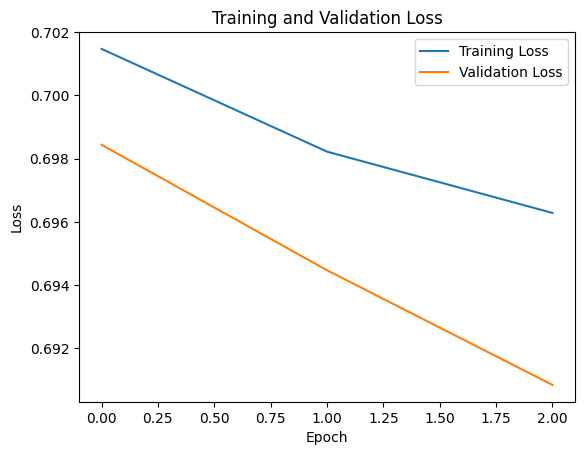

In [ ]:
# 6. Training loop
epochs = 3  # For demonstration purposes
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_loader):
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, axis=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [ ]:
# 9. Demonstrate the model on sample examples
def predict_sentiment(text, model, tokenizer):
    encoding = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        prediction = torch.argmax(logits, axis=1).item()
    return "Positive" if prediction == 1 else "Negative"

sample_texts = ["good", "The plot was dull and boring.", "Absolutely loved the cinematography."]
for text in sample_texts:
    sentiment = predict_sentiment(text, model, tokenizer)
    print(f"Review: {text} | Sentiment: {sentiment}")

Review: good | Sentiment: Positive
Review: The plot was dull and boring. | Sentiment: Negative
Review: Absolutely loved the cinematography. | Sentiment: Positive


In [ ]:
# 7. Save and load the model
torch.save(model.state_dict(), 'bert_sentiment_model.pth')  # Save model
print("Model saved!")

# Correct way to load from a local .pth file:
loaded_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
loaded_model = get_peft_model(loaded_model, lora_config) # Apply LoRA to the loaded model
loaded_model.load_state_dict(torch.load('bert_sentiment_model.pth')) # Load the weights
loaded_model.to(device)
loaded_model.eval()

Model saved!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-84-18e6b5170451>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [ ]:


# 8. Evaluate the model on the test set
predictions = []
true_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for i, (input_ids, attention_mask, labels) in enumerate(test_loader):
        if i >= 10:
          break
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Print the classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, predictions))


Test Accuracy: 0.5203

Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.40      0.46       332
           1       0.50      0.65      0.57       308

    accuracy                           0.52       640
   macro avg       0.53      0.53      0.51       640
weighted avg       0.53      0.52      0.51       640



GPT2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model
from torch.cuda.amp import autocast, GradScaler

# 1. Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = load_dataset("imdb")

# Sample 10% from train and split test into 80% for test, 20% for validation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
train_data_sampled = np.random.choice(len(train_data), size=int(len(train_data) * 0.1), replace=False)
train_data_sampled = [train_data[i] for i in train_data_sampled]

test_data = list(zip(dataset['test']['text'], dataset['test']['label']))
val_size = int(len(test_data) * 0.2)
test_data, val_data = random_split(test_data, [len(test_data) - val_size, val_size])

# Unzip data into features and labels
X_train, y_train = zip(*train_data_sampled)
X_test, y_test = zip(*test_data)
X_val, y_val = zip(*val_data)

# Tokenization and Data Preparation
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = encoding['attention_mask'].squeeze(0)  # Remove batch dimension
        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set padding token to eos_token

# Create DataLoaders
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
val_dataset = SentimentDataset(X_val, y_val, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True)

# Define GPT-2-based model with PEFT LoRA
lora_config = LoraConfig(
    r=8, lora_alpha=32, lora_dropout=0.1, task_type="SEQ_CLS"
)

base_model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
# Update the pad_token_id in the model config
base_model.config.pad_token_id = base_model.config.eos_token_id
model = get_peft_model(base_model, lora_config)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Mixed precision setup
scaler = GradScaler()

Using device: cuda


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
<ipython-input-88-883fb13d3ce2>:88: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


<ipython-input-89-8ee8152d93e7>:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/3], Training Loss: 1.1634


<ipython-input-89-8ee8152d93e7>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7673, Validation Accuracy: 0.5074


<ipython-input-89-8ee8152d93e7>:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [2/3], Training Loss: 0.7337


<ipython-input-89-8ee8152d93e7>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7294, Validation Accuracy: 0.5452


<ipython-input-89-8ee8152d93e7>:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [3/3], Training Loss: 0.6926


<ipython-input-89-8ee8152d93e7>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6829, Validation Accuracy: 0.5972


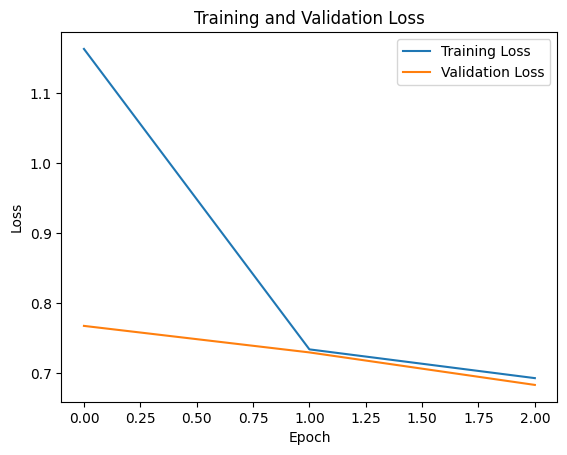

In [ ]:
# Training loop
epochs = 3
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_loader):
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Automatic mixed precision
        optimizer.zero_grad()
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, axis=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:

# Evaluate the model on the test set
predictions = []
true_labels = []

model.eval()
with torch.no_grad():
    for i, (input_ids, attention_mask, labels) in enumerate(test_loader):
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, axis=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Print the classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, predictions))


GPT2 - simple

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model

# 1. Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = load_dataset("imdb")

# Sample 10% from train and split test into 80% for test, 20% for validation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
train_data_sampled = np.random.choice(len(train_data), size=int(len(train_data) * 0.1), replace=False)
train_data_sampled = [train_data[i] for i in train_data_sampled]

test_data = list(zip(dataset['test']['text'], dataset['test']['label']))
val_size = int(len(test_data) * 0.2)
test_data, val_data = random_split(test_data, [len(test_data) - val_size, val_size])

# Unzip data into features and labels
X_train, y_train = zip(*train_data_sampled)
X_test, y_test = zip(*test_data)
X_val, y_val = zip(*val_data)

# Print lengths
print(len(X_train), len(X_test), len(X_val))

# Tokenization and Data Preparation
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = encoding['attention_mask'].squeeze(0)  # Remove batch dimension
        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set padding token to eos_token

# Create DataLoaders
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
val_dataset = SentimentDataset(X_val, y_val, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define GPT-2-based model with PEFT LoRA
lora_config = LoraConfig(
    r=8, lora_alpha=32, lora_dropout=0.1, task_type="SEQ_CLS"
)

base_model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
# Update the pad_token_id in the model config
base_model.config.pad_token_id = base_model.config.eos_token_id
model = get_peft_model(base_model, lora_config)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

Using device: cuda
2500 20000 5000


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Training Loss: 1.0605
Validation Loss: 0.7983, Validation Accuracy: 0.5172
Epoch [2/3], Training Loss: 0.7014
Validation Loss: 0.6964, Validation Accuracy: 0.5936
Epoch [3/3], Training Loss: 0.6221
Validation Loss: 0.6041, Validation Accuracy: 0.6980


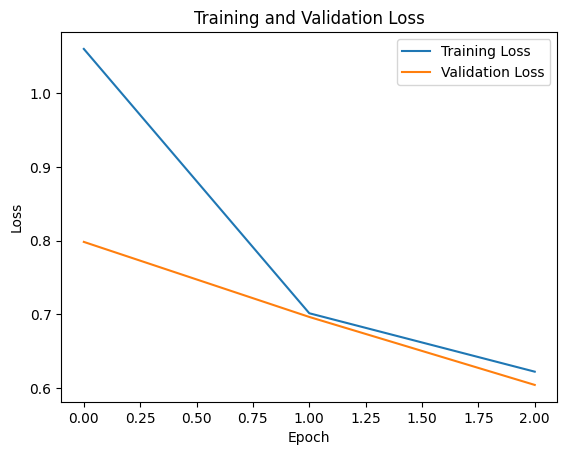

In [ ]:
# Training loop
epochs = 3
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_loader):
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, axis=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()




In [ ]:
# Evaluate the model on the test set
predictions = []
true_labels = []

model.eval()
with torch.no_grad():
    for i, (input_ids, attention_mask, labels) in enumerate(test_loader):
        if i >= 10:
          break
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Print the classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, predictions))

Test Accuracy: 0.6250

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.48      0.63        27
           1       0.46      0.92      0.62        13

    accuracy                           0.62        40
   macro avg       0.70      0.70      0.62        40
weighted avg       0.78      0.62      0.63        40

